In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import copy
import os

import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import gpytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import tqdm

# Import code from src
sys.path.insert(0, '..')
from data_preprocessing import transform_data, load_data, scale_features
from mlmodels import MLP, ExactGP, NNKernel, train_and_test, train_and_test_w_batching
from plotter_functions import plot_lineplot

## Loading data

In [2]:
fig_path = "/home/jeb/Desktop/MScProject/results/figures/"
data_path = "/home/jeb/Documents/MScProject/Project/datasets/data_Vaska"
gp = "/gpVaska_vectors.csv"
nbo = "/nboVaska_vectors.csv"
target = "target_barrier"
df, target = load_data(data_path+gp, target)

# Scale features and split 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1233)
x_train = x_train.to_numpy(); x_test = x_test.to_numpy()
y_train = y_train.to_numpy()#.reshape(len(y_train), 1)
y_test = y_test.to_numpy()#.reshape(len(y_test), 1)
x_train, x_test = scale_features(x_train, x_test)
x_train = torch.from_numpy(x_train); x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train); y_test = torch.from_numpy(y_test)


## Neural Network

Running on 1030/1030 features.


  5%|██                                      | 102/2000 [00:04<01:28, 21.51it/s]

Epoch [100/2000], Loss: 5.7501


 10%|████                                    | 204/2000 [00:09<01:23, 21.51it/s]

Epoch [200/2000], Loss: 2.6561


 15%|██████                                  | 303/2000 [00:14<01:18, 21.49it/s]

Epoch [300/2000], Loss: 2.3893


 20%|████████                                | 402/2000 [00:18<01:14, 21.37it/s]

Epoch [400/2000], Loss: 2.4281


 25%|██████████                              | 504/2000 [00:23<01:10, 21.23it/s]

Epoch [500/2000], Loss: 2.4171


 30%|████████████                            | 603/2000 [00:28<01:05, 21.31it/s]

Epoch [600/2000], Loss: 2.2687


 35%|██████████████                          | 702/2000 [00:32<01:01, 21.23it/s]

Epoch [700/2000], Loss: 2.1106


 40%|████████████████                        | 804/2000 [00:37<00:56, 21.15it/s]

Epoch [800/2000], Loss: 2.1129


 45%|██████████████████                      | 903/2000 [00:42<00:51, 21.31it/s]

Epoch [900/2000], Loss: 2.3877


 50%|███████████████████▌                   | 1002/2000 [00:46<00:46, 21.36it/s]

Epoch [1000/2000], Loss: 1.9720


 55%|█████████████████████▌                 | 1104/2000 [00:51<00:41, 21.36it/s]

Epoch [1100/2000], Loss: 2.0198


 60%|███████████████████████▍               | 1203/2000 [00:56<00:37, 21.37it/s]

Epoch [1200/2000], Loss: 1.8201


 65%|█████████████████████████▍             | 1302/2000 [01:01<00:32, 21.30it/s]

Epoch [1300/2000], Loss: 2.0493


 70%|███████████████████████████▍           | 1404/2000 [01:05<00:27, 21.37it/s]

Epoch [1400/2000], Loss: 1.7565


 75%|█████████████████████████████▎         | 1503/2000 [01:10<00:23, 21.17it/s]

Epoch [1500/2000], Loss: 1.7793


 80%|███████████████████████████████▏       | 1602/2000 [01:15<00:18, 21.25it/s]

Epoch [1600/2000], Loss: 1.8493


 85%|█████████████████████████████████▏     | 1704/2000 [01:19<00:14, 21.10it/s]

Epoch [1700/2000], Loss: 1.8028


 90%|███████████████████████████████████▏   | 1803/2000 [01:24<00:09, 21.15it/s]

Epoch [1800/2000], Loss: 1.6385


 95%|█████████████████████████████████████  | 1902/2000 [01:29<00:04, 21.37it/s]

Epoch [1900/2000], Loss: 1.6419


100%|███████████████████████████████████████| 2000/2000 [01:33<00:00, 21.32it/s]


Epoch [2000/2000], Loss: 1.6479
R2 Train: 0.9810604560721641
R2 Test: 0.9037664075360424


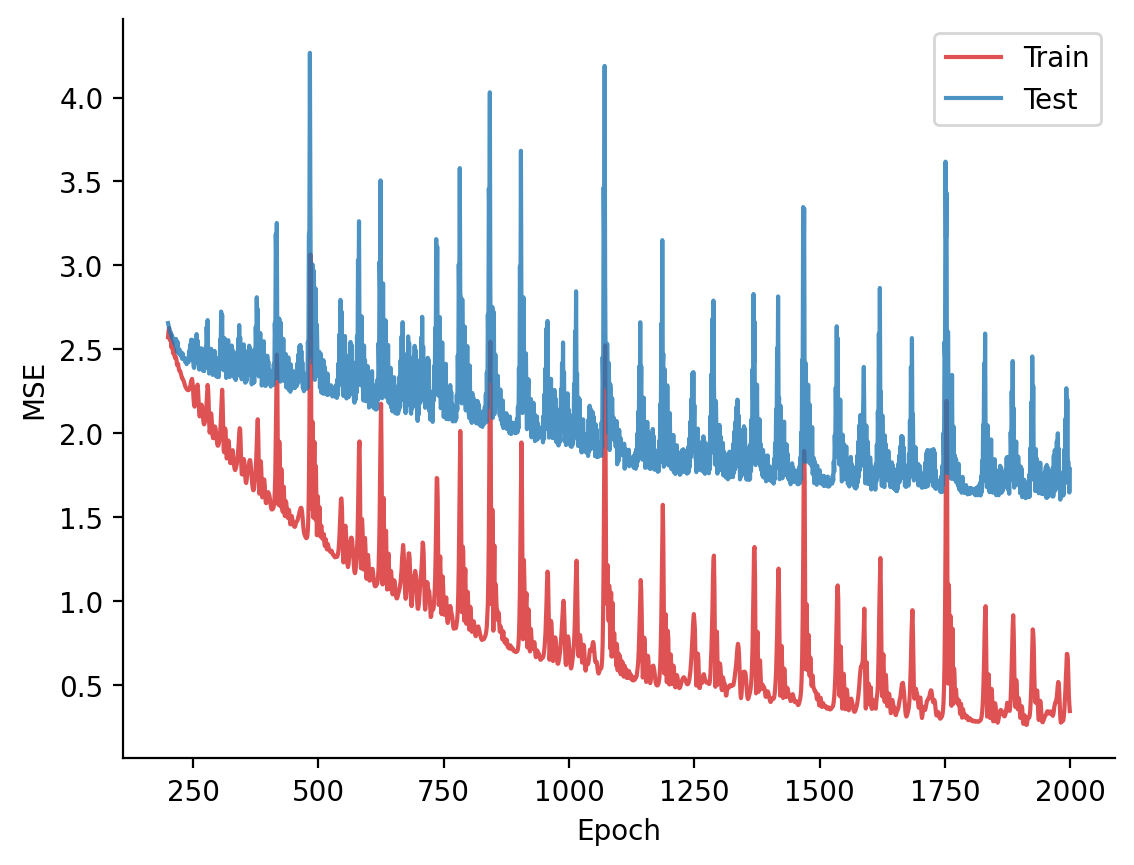

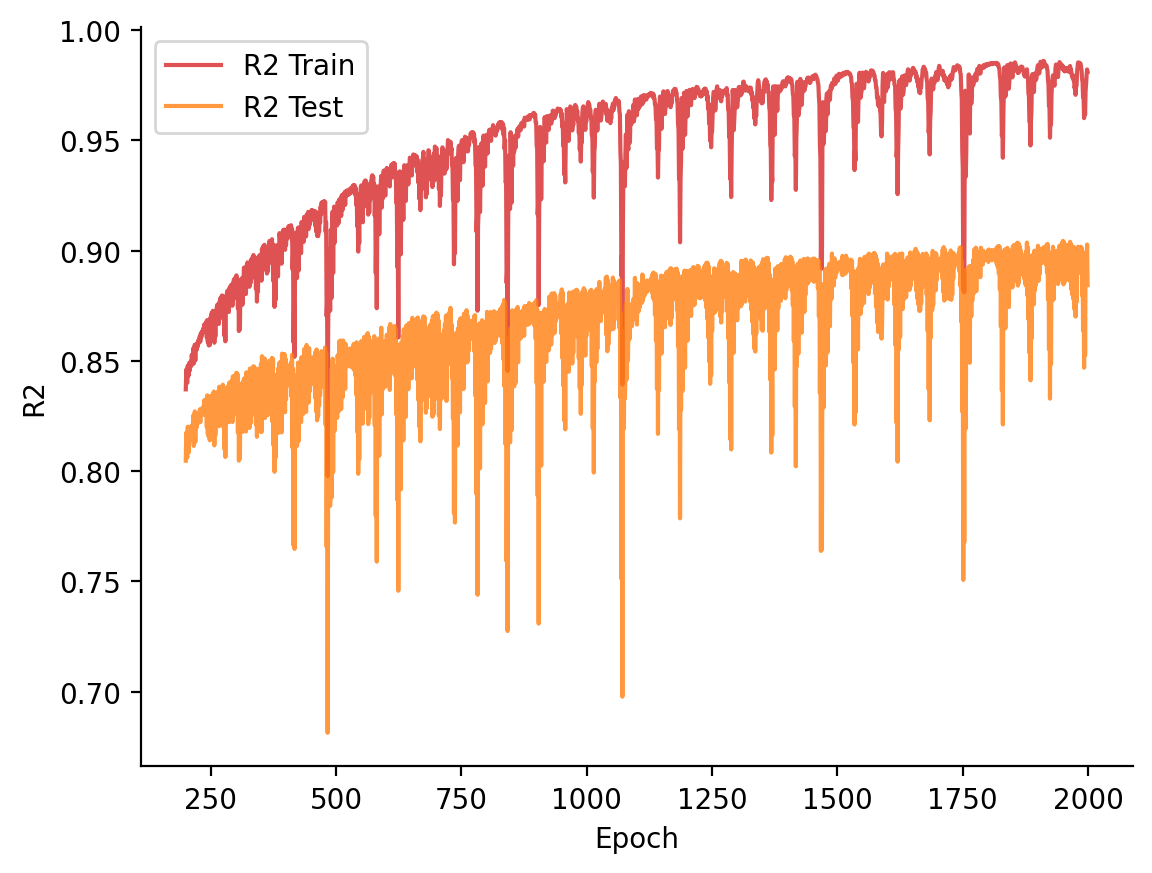

In [6]:
width = 247
depth = 4
n_features = x_train.shape[-1]
n_targets = 1
print(f"Running on {n_features}/1030 features.")
model = MLP(n_features, n_targets, depth, width)

if torch.cuda.is_available():
    x_train = x_train.cuda(); x_test = x_test.cuda()
    y_train = y_train.cuda(); y_test = y_test.cuda()
    model = model.cuda()

# Loss and optimizer
lr = 1e-3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

epochs = 2000
train_err, test_err, preds, output, r2_test, r2_train = train_and_test(x_train, 
                                                                       x_test, 
                                                                       y_train, 
                                                                       y_test, 
                                                                       epochs, 
                                                                       model, 
                                                                       criterion, 
                                                                       optimizer, 
                                                                       scheduler)
y_train = y_train.cpu(); y_test = y_test.cpu()
preds = preds.cpu().numpy(); output = output.cpu().detach().numpy()
model.eval()
output = model(x_train)
R2_Train = r2_score(y_train, output.cpu().detach().numpy())
R2_test = r2_score(y_test, preds)
print(f"R2 Train: {R2_Train}")
print(f"R2 Test: {R2_test}")

#r2=plot_lineplot(np.array([i for i in range(epochs)]), [R2_Train, R2_test],["Train", "Test"], "Epoch", "R2", ["tab:red", "tab:blue"], fig_path, "R2.pdf")
MSE=plot_lineplot(np.array([i for i in range(200, epochs, 1)]),
                  [train_err[199:-1], test_err[199:-1]],
                  ["Train", "Test"],
                  "Epoch",
                  "MSE",
                  ["tab:red", "tab:blue"],
                  fig_path,
                  "MSE_neural_net.pdf")
R2=plot_lineplot(np.array([i for i in range(200, epochs, 1)]),
                 [r2_train[199:-1], r2_test[199:-1]],
                 ["R2 Train", "R2 Test"],
                 "Epoch",
                 "R2",
                 ["tab:red", "tab:orange"],
                 fig_path,
                 "R2_neural_net.pdf")

## Neural Network using 49 most relevant features. 

Running on 49/1030 features.
Cuda available: True


  5%|██▏                                     | 109/2000 [00:02<00:39, 47.71it/s]

Epoch [100/2000], Loss: 5.1204


 10%|████▏                                   | 209/2000 [00:04<00:37, 47.49it/s]

Epoch [200/2000], Loss: 2.8825


 15%|██████▏                                 | 309/2000 [00:06<00:35, 47.17it/s]

Epoch [300/2000], Loss: 2.3689


 20%|████████▏                               | 409/2000 [00:08<00:33, 47.71it/s]

Epoch [400/2000], Loss: 2.2523


 25%|██████████▏                             | 509/2000 [00:10<00:31, 47.73it/s]

Epoch [500/2000], Loss: 2.0904


 30%|████████████▏                           | 609/2000 [00:12<00:29, 47.75it/s]

Epoch [600/2000], Loss: 2.0373


 35%|██████████████▏                         | 709/2000 [00:14<00:27, 47.71it/s]

Epoch [700/2000], Loss: 2.0569


 40%|████████████████▏                       | 809/2000 [00:17<00:25, 47.51it/s]

Epoch [800/2000], Loss: 2.1120


 45%|██████████████████▏                     | 909/2000 [00:19<00:22, 47.52it/s]

Epoch [900/2000], Loss: 2.1279


 50%|███████████████████▋                   | 1009/2000 [00:21<00:20, 47.49it/s]

Epoch [1000/2000], Loss: 1.9857


 55%|█████████████████████▋                 | 1109/2000 [00:23<00:18, 47.52it/s]

Epoch [1100/2000], Loss: 1.9633


 60%|███████████████████████▌               | 1209/2000 [00:25<00:16, 47.51it/s]

Epoch [1200/2000], Loss: 2.0520


 65%|█████████████████████████▌             | 1309/2000 [00:27<00:14, 47.57it/s]

Epoch [1300/2000], Loss: 2.0016


 70%|███████████████████████████▍           | 1409/2000 [00:29<00:12, 47.50it/s]

Epoch [1400/2000], Loss: 2.0355


 75%|█████████████████████████████▍         | 1509/2000 [00:31<00:10, 47.53it/s]

Epoch [1500/2000], Loss: 2.1568


 80%|███████████████████████████████▍       | 1609/2000 [00:33<00:08, 47.42it/s]

Epoch [1600/2000], Loss: 2.0875


 85%|█████████████████████████████████▎     | 1709/2000 [00:36<00:06, 46.83it/s]

Epoch [1700/2000], Loss: 2.0484


 90%|███████████████████████████████████▎   | 1809/2000 [00:38<00:04, 47.51it/s]

Epoch [1800/2000], Loss: 2.1212


 95%|█████████████████████████████████████▏ | 1909/2000 [00:40<00:01, 47.55it/s]

Epoch [1900/2000], Loss: 2.0105


100%|███████████████████████████████████████| 2000/2000 [00:42<00:00, 47.45it/s]


Epoch [2000/2000], Loss: 2.0158
R2 Train: 0.9927624452208322
R2 Test: 0.8822815676828255


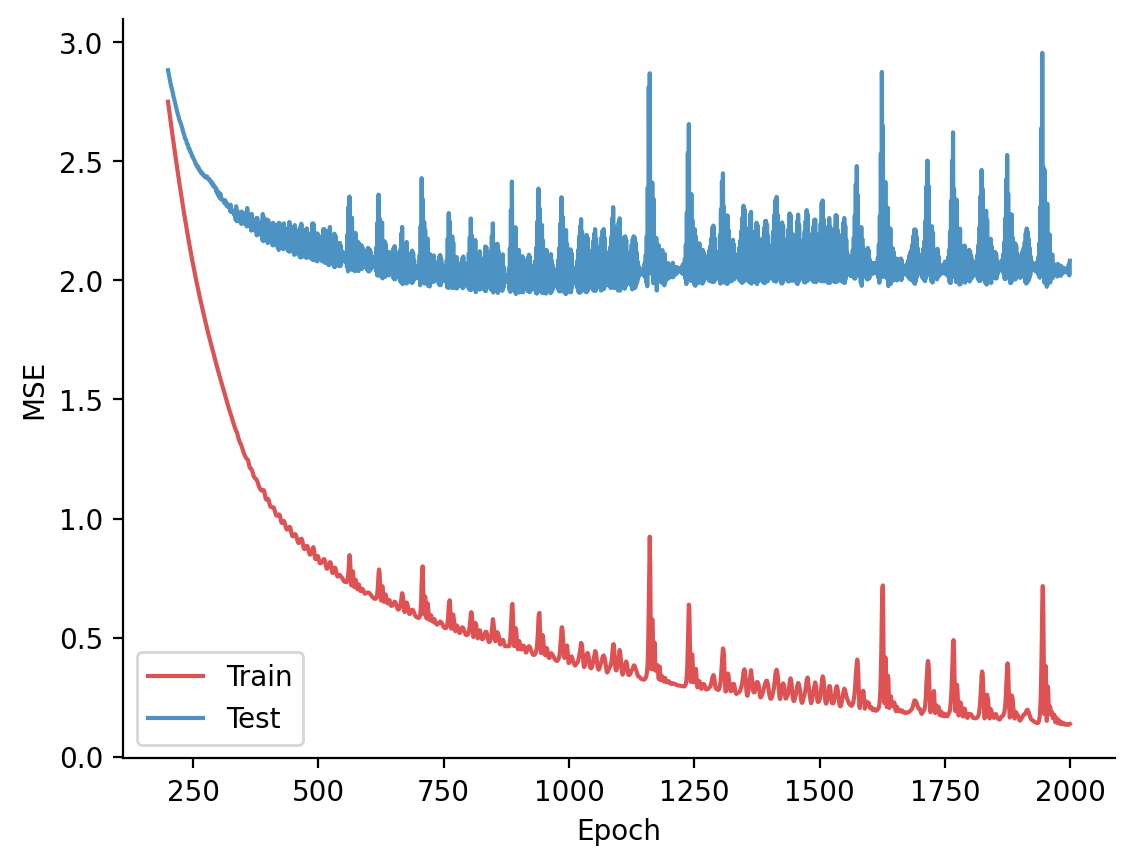

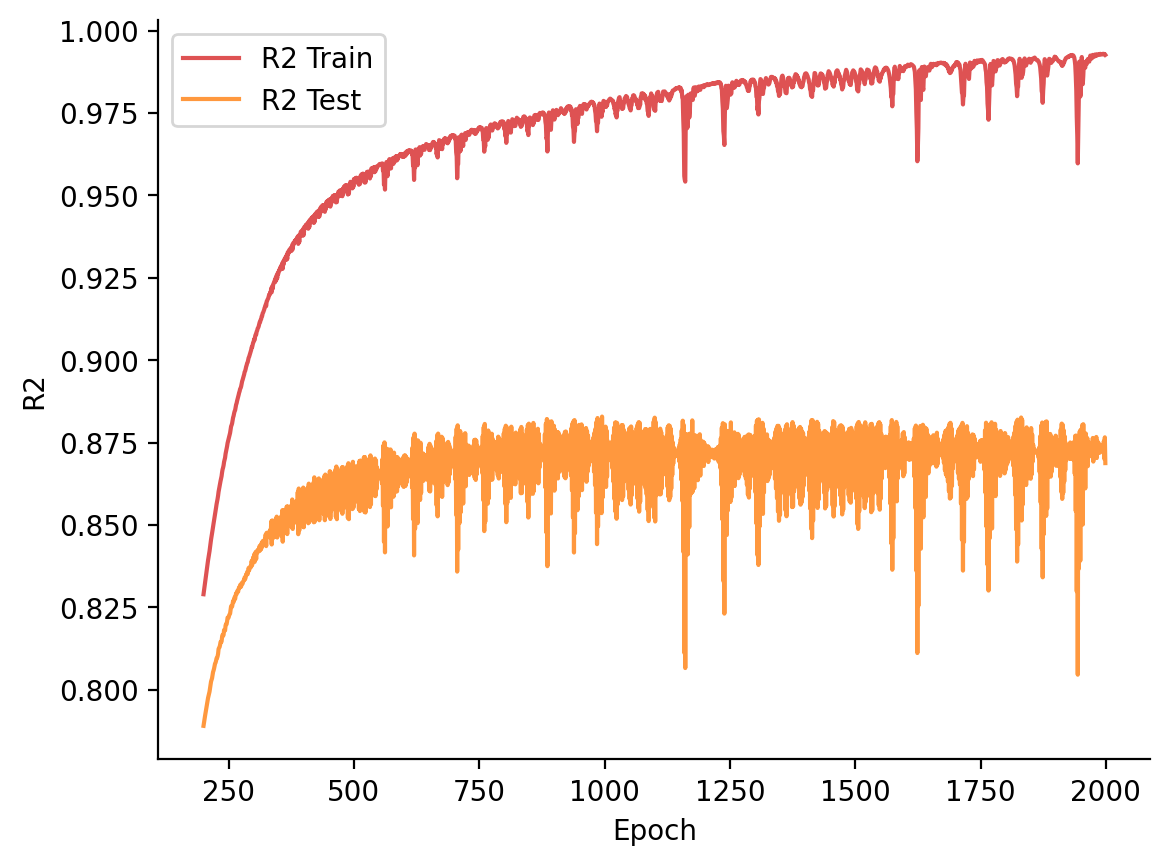

In [7]:
reduced_feature_set = ['Z-5_FS_AA','I-3_FD_AB','d-1_MR_BB','Z-0_FD_AB','Z-3_FR_AA','d-2_MA_BB',
                       'BO-4_FA_BB','Z-1_FD_AB','d-1_MR_AB','Z-5_FD_AB','chi-0_MS_AB',
                       'd-1_MD_BB','T-2_MR_AA','chi-2_MR_AA','Z-2_FR_AA','S-1_MS_AA',
                       'd-1_MS_BBavg','S-1_MD_AA','S-1_MA_AA','chi-0_MD_AB','S-2_MR_AA',
                       'I-0_MR_AB','Z-1_MR_AA','d-1_MA_BBavg','I-1_MD_AB','Z-1_MA_AA',
                       'chi-1_MS_AA','chi-3_MD_AA','S-2_MD_AB','chi-0_FA_AB','T-6_FD_AB',
                       'Z-2_MR_AA','chi-1_MR_AA','d-0_MR_AB','Z-0_FA_AA','d-1_MR_BBavg',
                       'S-1_MR_AA','chi-1_MA_AA','I-2_MD_AB','d-0_MS_BBavg','BO-1_MD_BBavg',
                       'S-0_MD_AB','BO-2_MD_BBavg','d-0_MA_BBavg','Z-1_FA_AA','BO-0_MR_AB',
                       'Z-2_FA_AA','d-1_MD_BBavg','chi-1_MD_AA']
# Scale features and split 
x_train, x_test, y_train, y_test = train_test_split(df[reduced_feature_set], target, test_size=0.2, random_state=1233)
x_train = x_train.to_numpy(); x_test = x_test.to_numpy()
y_train = y_train.to_numpy().reshape(len(y_train), 1)
y_test = y_test.to_numpy().reshape(len(y_test), 1)
x_train, x_test = scale_features(x_train, x_test)
x_train = torch.from_numpy(x_train); x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train); y_test = torch.from_numpy(y_test)
width = 247
depth = 4
n_features = x_train.shape[-1]
n_targets = 1
print(f"Running on {n_features}/1030 features.")
model = MLP(n_features, n_targets, depth, width)
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    x_train = x_train.cuda(); x_test = x_test.cuda()
    y_train = y_train.cuda(); y_test = y_test.cuda()
    model = model.cuda()

# Loss and optimizer
lr = 1e-3
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.5)

epochs = 2000
train_err, test_err, preds, output, r2_test, r2_train = train_and_test(x_train, 
                                                                       x_test, 
                                                                       y_train, 
                                                                       y_test, 
                                                                       epochs, 
                                                                       model, 
                                                                       criterion, 
                                                                       optimizer, 
                                                                       scheduler)
y_train = y_train.cpu(); y_test = y_test.cpu()
preds = preds.cpu().numpy(); output = output.cpu().detach().numpy()
model.eval()
output = model(x_train)
R2_Train = r2_score(y_train, output.cpu().detach().numpy())
R2_test = r2_score(y_test, preds)
print(f"R2 Train: {R2_Train}")
print(f"R2 Test: {R2_test}")

#r2=plot_lineplot(np.array([i for i in range(epochs)]), [R2_Train, R2_test],["Train", "Test"], "Epoch", "R2", ["tab:red", "tab:blue"], fig_path, "R2.pdf")
MSE=plot_lineplot(np.array([i for i in range(200, epochs, 1)]),
                  [train_err[199:-1], test_err[199:-1]],
                  ["Train", "Test"],
                  "Epoch",
                  "MSE",
                  ["tab:red", "tab:blue"],
                  fig_path,
                  "MSE_neural_net_reduced.pdf")
R2=plot_lineplot(np.array([i for i in range(200, epochs, 1)]),
                 [r2_train[199:-1], r2_test[199:-1]],
                 ["R2 Train", "R2 Test"],
                 "Epoch",
                 "R2",
                 ["tab:red", "tab:orange"],
                 fig_path,
                 "R2_neural_net_reduced.pdf")

## GP

Number of features:  1030
Cuda available: True
Devices available: 1


100%|████████████████████████████| 2000/2000 [09:30<00:00,  3.50it/s, loss=2.76]


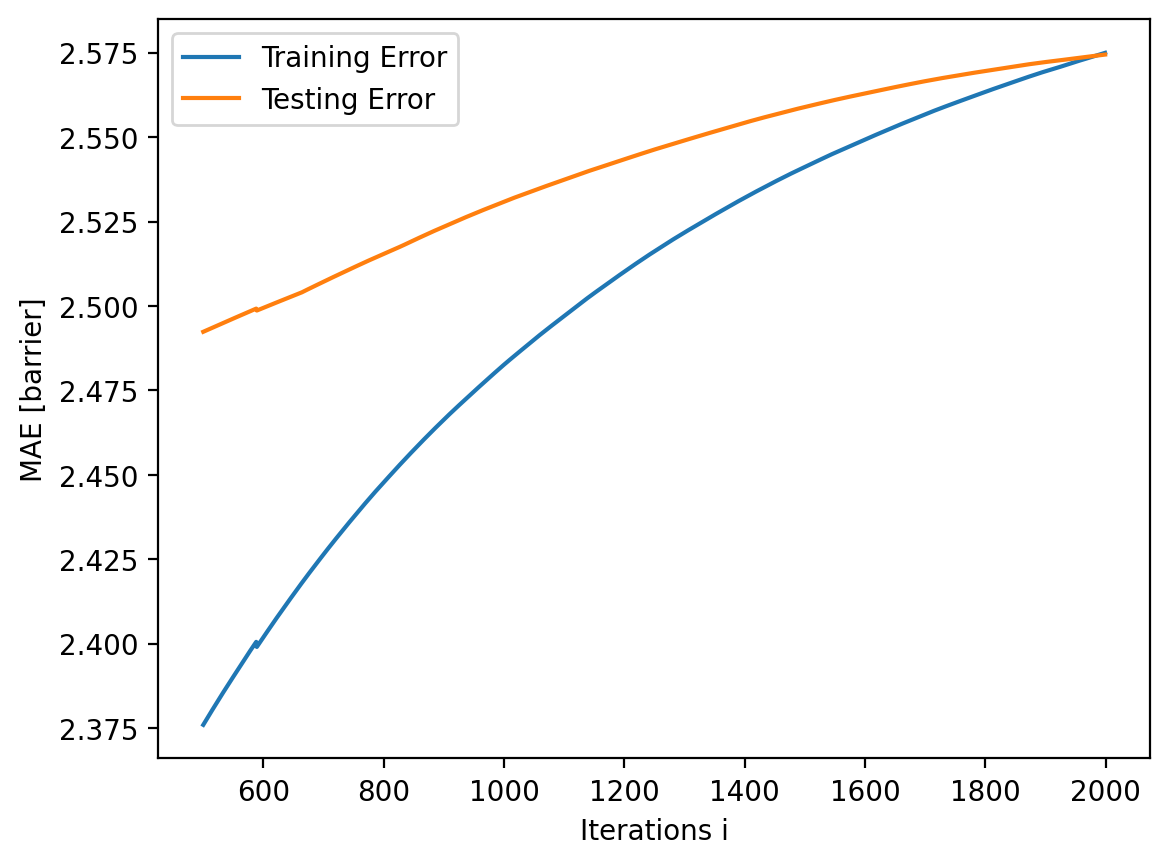

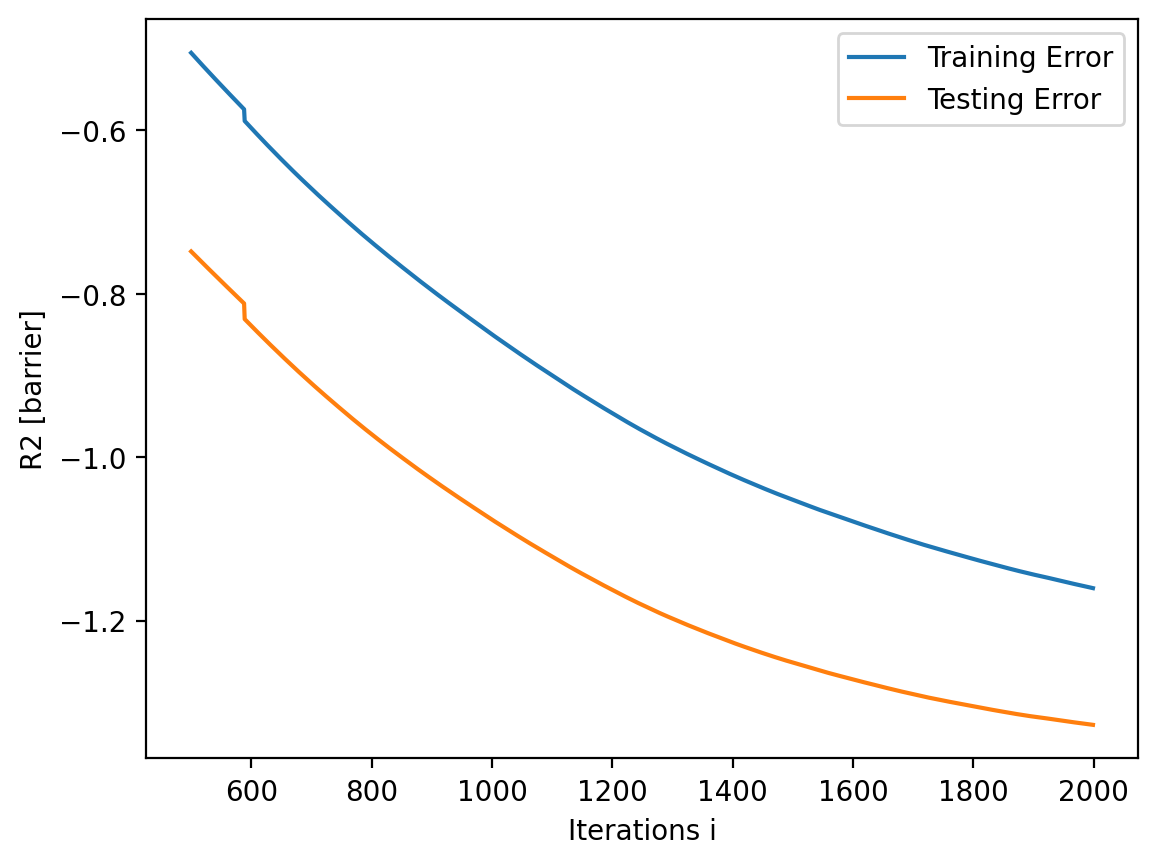

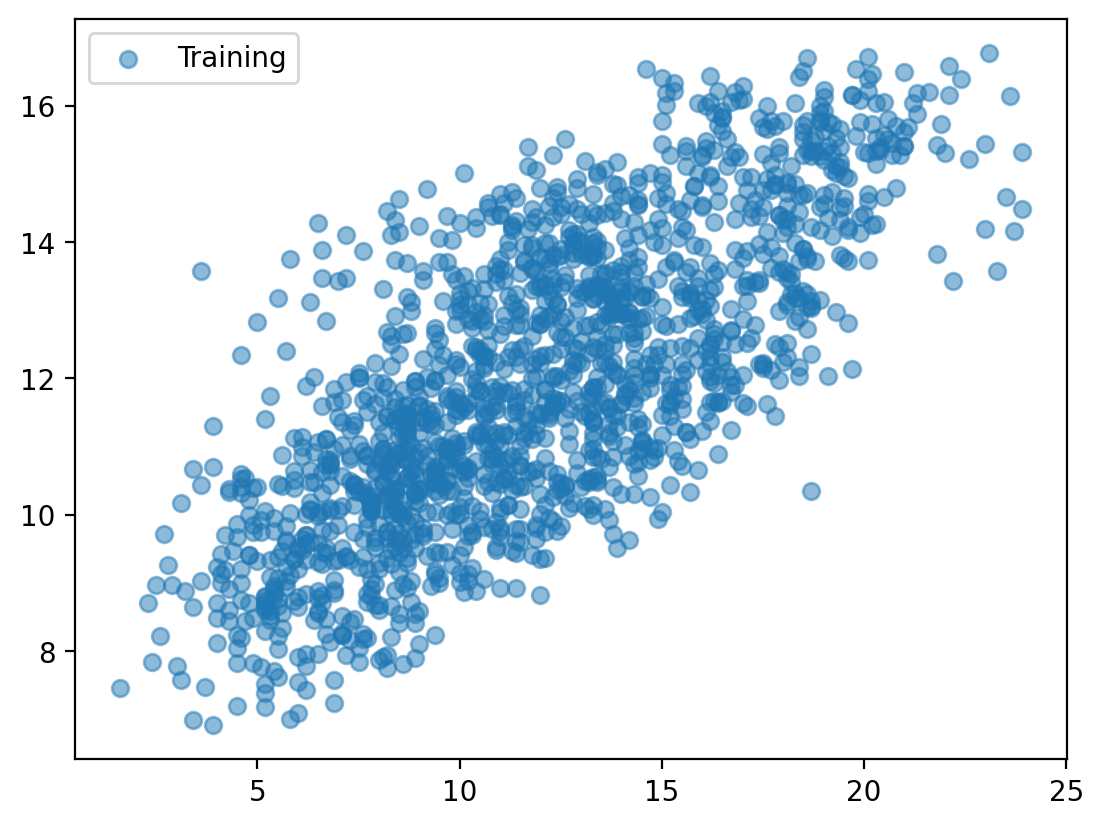

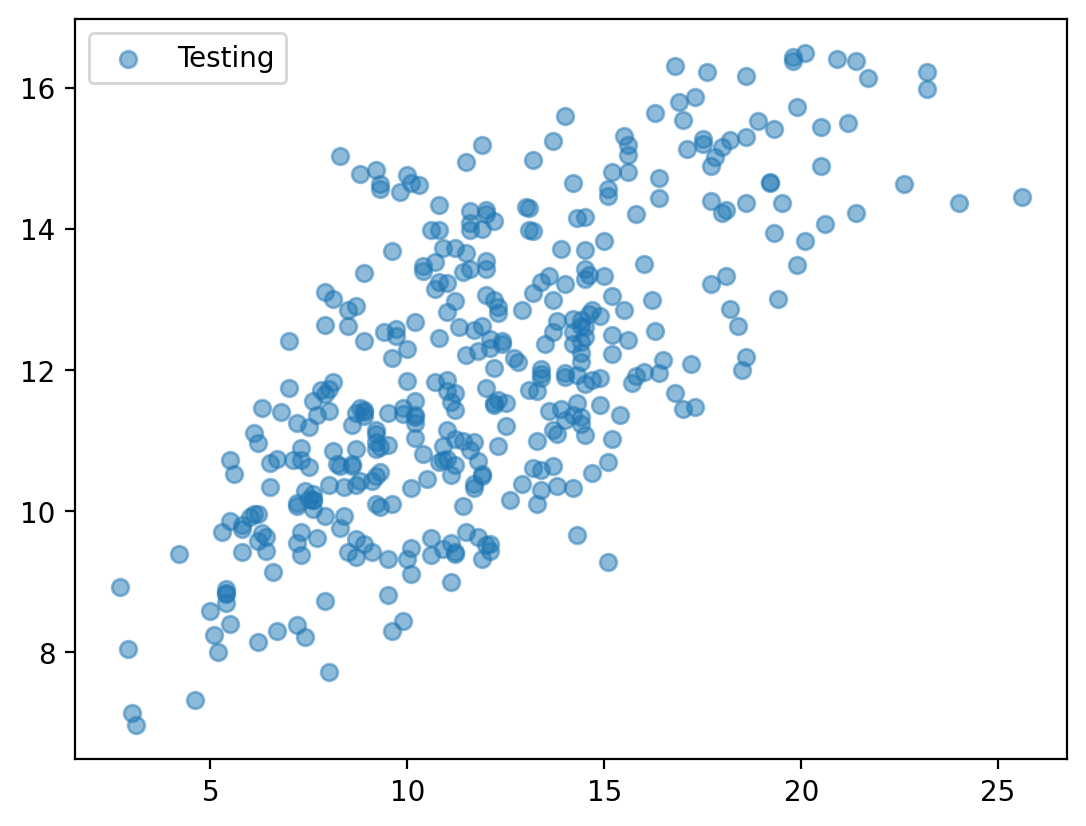

In [16]:
reduced_feature_set = ['Z-5_FS_AA','I-3_FD_AB','d-1_MR_BB','Z-0_FD_AB','Z-3_FR_AA','d-2_MA_BB',
                       'BO-4_FA_BB','Z-1_FD_AB','d-1_MR_AB','Z-5_FD_AB','chi-0_MS_AB',
                       'd-1_MD_BB','T-2_MR_AA','chi-2_MR_AA','Z-2_FR_AA','S-1_MS_AA',
                       'd-1_MS_BBavg','S-1_MD_AA','S-1_MA_AA','chi-0_MD_AB','S-2_MR_AA',
                       'I-0_MR_AB','Z-1_MR_AA','d-1_MA_BBavg','I-1_MD_AB','Z-1_MA_AA',
                       'chi-1_MS_AA','chi-3_MD_AA','S-2_MD_AB','chi-0_FA_AB','T-6_FD_AB',
                       'Z-2_MR_AA','chi-1_MR_AA','d-0_MR_AB','Z-0_FA_AA','d-1_MR_BBavg',
                       'S-1_MR_AA','chi-1_MA_AA','I-2_MD_AB','d-0_MS_BBavg','BO-1_MD_BBavg',
                       'S-0_MD_AB','BO-2_MD_BBavg','d-0_MA_BBavg','Z-1_FA_AA','BO-0_MR_AB',
                       'Z-2_FA_AA','d-1_MD_BBavg','chi-1_MD_AA']
# Scale features and split 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1233)
x_train = x_train.to_numpy(); x_test = x_test.to_numpy()
y_train = y_train.to_numpy().reshape(len(y_train))
y_test = y_test.to_numpy().reshape(len(y_test))
x_train, x_test = scale_features(x_train, x_test)
x_train = torch.from_numpy(x_train); x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train); y_test = torch.from_numpy(y_test)

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGP(x_train, y_train, likelihood, ard_dims=100) #x_train.shape[1]-1
print("Number of features: ", x_train.shape[1])

optimizer = torch.optim.Adam(model.parameters(), lr=5e-2)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 2000


print(f"Cuda available: {torch.cuda.is_available()}")
n_devices = torch.cuda.device_count()
print(f"Devices available: {n_devices}")
if torch.cuda.is_available():
    x_train = x_train.cuda(); x_test = x_test.cuda()
    y_train = y_train.cuda(); y_test = y_test.cuda()
    model = model.cuda(); likelihood = likelihood.cuda()


def train_and_store_energies():
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
    error_train = np.zeros(training_iter)
    error_test = np.zeros(training_iter)
    r2_train = np.zeros(training_iter)
    r2_test = np.zeros(training_iter)
    model.train()
    likelihood.train()
    iterator = tqdm.tqdm(range(training_iter))
    for i in iterator:
        optimizer.zero_grad()

        output = likelihood(model(x_train))
        loss = torch.sum(-mll(output, y_train))
        loss.backward()

        #print('Iter %d/%d - Loss: %.3f' % (
        #        i + 1, training_iter, loss.item()))

        iterator.set_postfix(loss=loss.item())
        optimizer.step()

        if i % 1 == 0:
            model.eval()
            likelihood.eval()
            # gpytorch.settings.usetoeplitz(False)
            with torch.no_grad(),gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
                preds = likelihood(model(x_test))
                train_preds = likelihood(model(x_train))

            model.train()
            likelihood.train()
            # Mean absolute error
            error_train[i] = torch.mean(torch.abs(train_preds.mean.cpu() - y_train.cpu()))
            error_test[i] = torch.mean(torch.abs(preds.mean.cpu() - y_test.cpu()))
            r2_train[i] = r2_score(train_preds.mean.cpu(), y_train.cpu())
            r2_test[i] = r2_score(preds.mean.cpu(), y_test.cpu())

        #if (i+1) % 50 == 0:
            #scheduler.step()
    return error_train, error_test, r2_train, r2_test, train_preds.mean.cpu(), preds.mean.cpu()


error_train, error_test, r2_train, r2_test, train_preds, preds = train_and_store_energies()
error_train = error_train; error_test = error_test
train_preds = train_preds; preds = preds
plt.figure()
plt.plot(range(500, training_iter, 1), error_train[499:-1], label="Training Error")
plt.plot(range(500, training_iter, 1), error_test[499:-1], label="Testing Error")
plt.xlabel("Iterations i")
plt.ylabel("MAE [barrier]")
plt.legend()
plt.savefig(fig_path + "ARD_MAE.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.plot(range(500, training_iter, 1), r2_train[499:-1], label="Training Error")
plt.plot(range(500, training_iter, 1), r2_test[499:-1], label="Testing Error")
plt.xlabel("Iterations i")
plt.ylabel("R2 [barrier]")
plt.legend()
plt.savefig(fig_path + "ARD_R2.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.scatter(y_train.cpu(), train_preds, label="Training", alpha=0.5)
plt.legend()
plt.savefig(fig_path + "ARD_train.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.scatter(y_test.cpu(), preds, label="Testing", alpha=0.5)
plt.legend()
plt.savefig(fig_path + "ARD_test.pdf", format="pdf", bbox_inches="tight")

100%|████████████████████████████| 2000/2000 [02:42<00:00, 12.30it/s, loss=1.48]


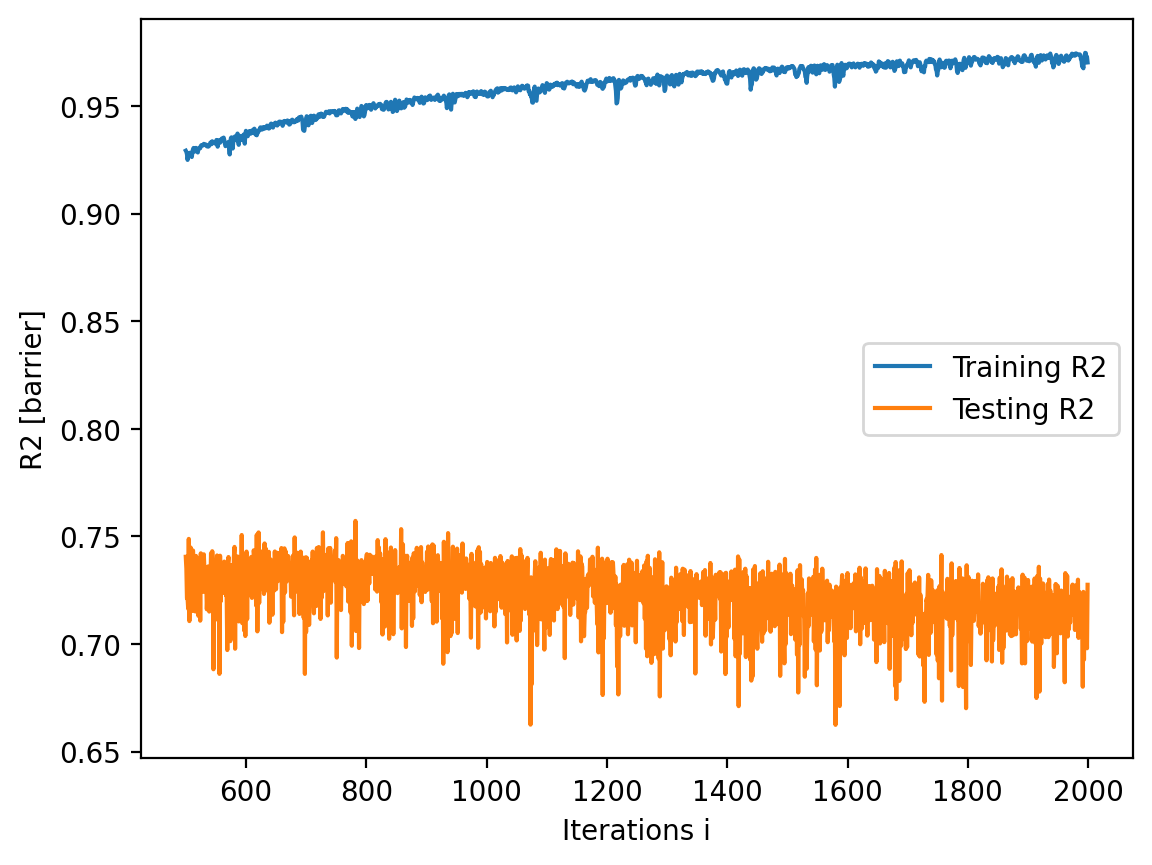

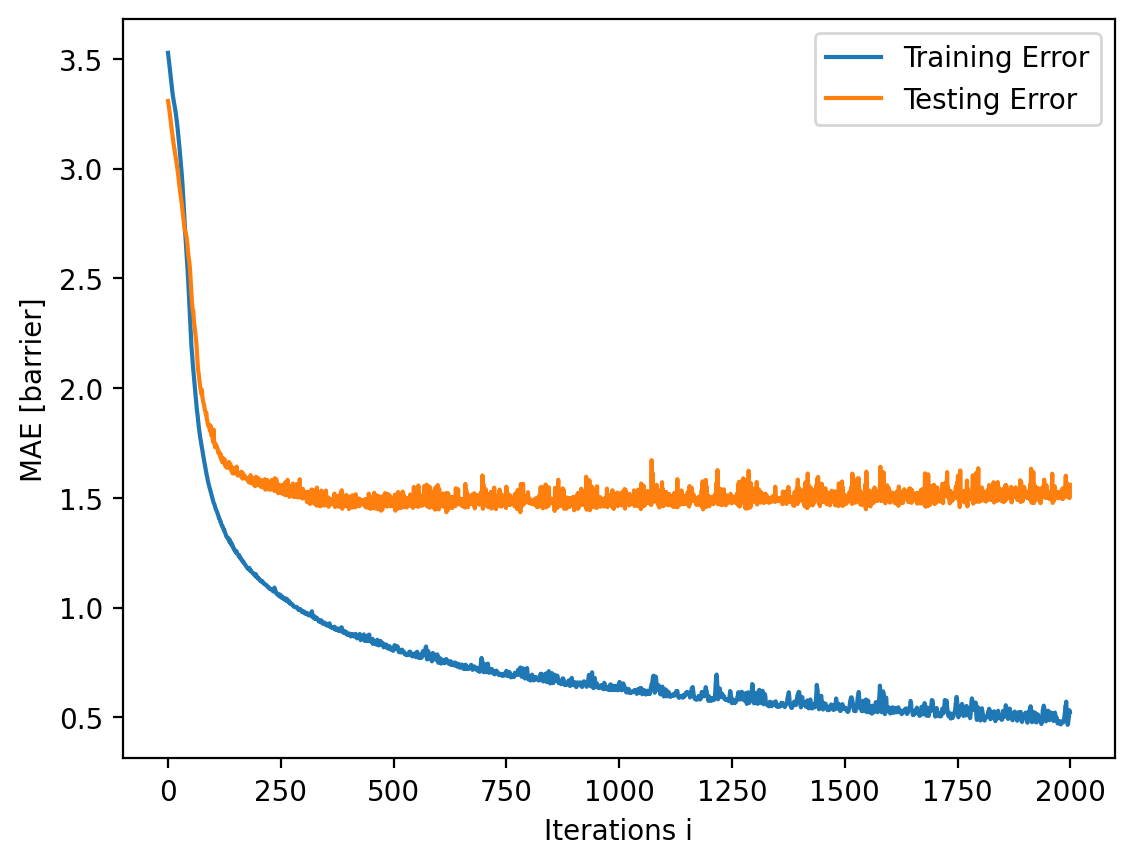

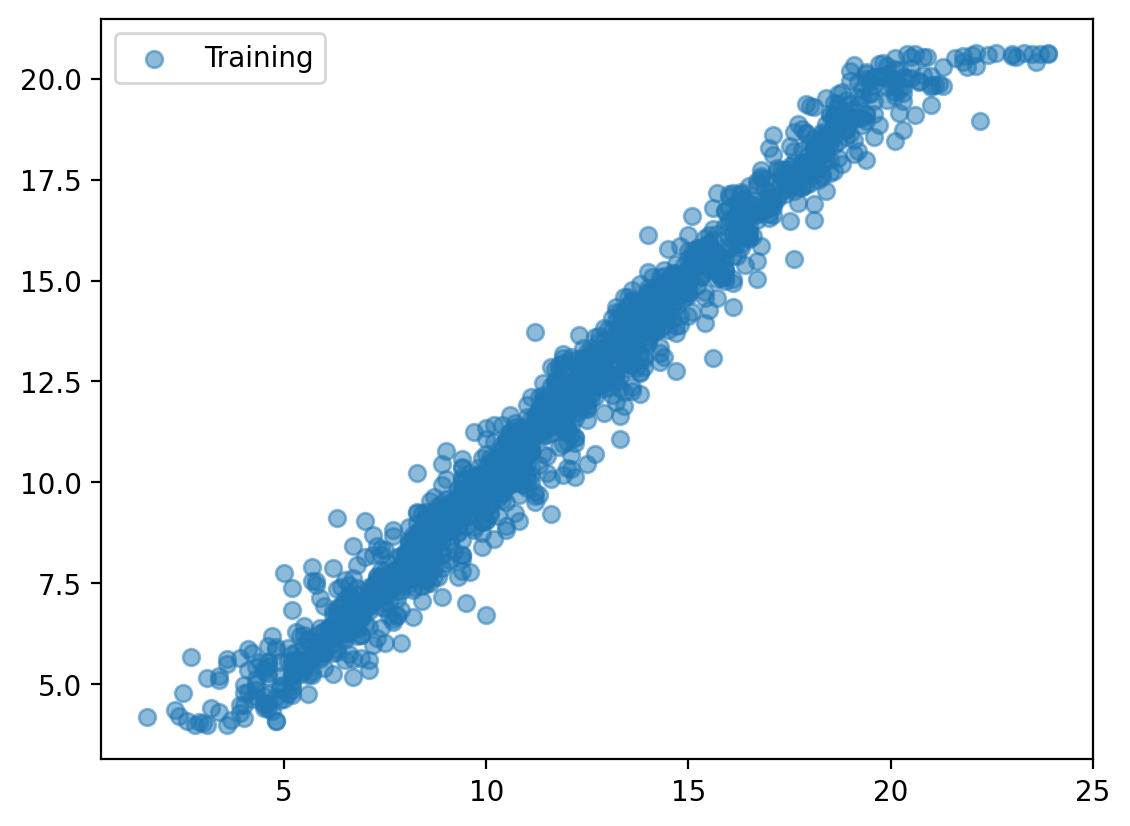

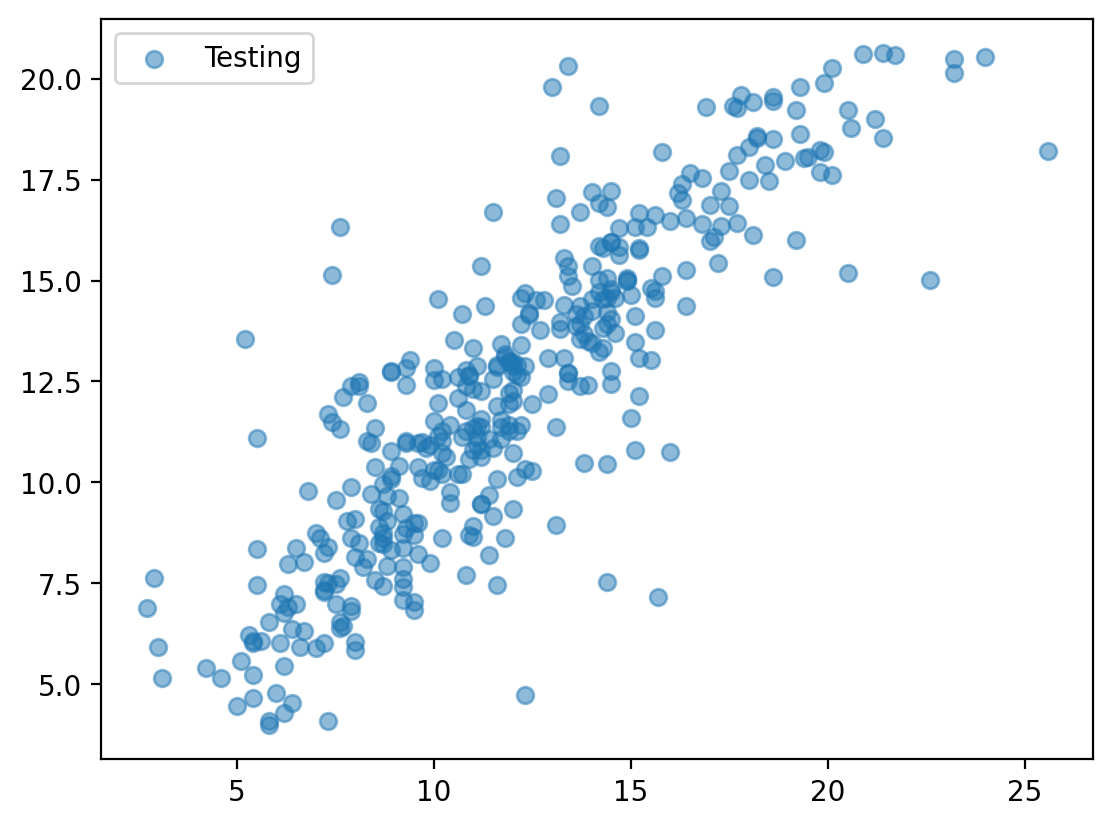

In [13]:
reduced_feature_set = ['Z-5_FS_AA','I-3_FD_AB','d-1_MR_BB','Z-0_FD_AB','Z-3_FR_AA','d-2_MA_BB',
                       'BO-4_FA_BB','Z-1_FD_AB','d-1_MR_AB','Z-5_FD_AB','chi-0_MS_AB',
                       'd-1_MD_BB','T-2_MR_AA','chi-2_MR_AA','Z-2_FR_AA','S-1_MS_AA',
                       'd-1_MS_BBavg','S-1_MD_AA','S-1_MA_AA','chi-0_MD_AB','S-2_MR_AA',
                       'I-0_MR_AB','Z-1_MR_AA','d-1_MA_BBavg','I-1_MD_AB','Z-1_MA_AA',
                       'chi-1_MS_AA','chi-3_MD_AA','S-2_MD_AB','chi-0_FA_AB','T-6_FD_AB',
                       'Z-2_MR_AA','chi-1_MR_AA','d-0_MR_AB','Z-0_FA_AA','d-1_MR_BBavg',
                       'S-1_MR_AA','chi-1_MA_AA','I-2_MD_AB','d-0_MS_BBavg','BO-1_MD_BBavg',
                       'S-0_MD_AB','BO-2_MD_BBavg','d-0_MA_BBavg','Z-1_FA_AA','BO-0_MR_AB',
                       'Z-2_FA_AA','d-1_MD_BBavg','chi-1_MD_AA']
# Scale features and split 
x_train, x_test, y_train, y_test = train_test_split(df, target, test_size=0.2, random_state=1233)
x_train = x_train.to_numpy(); x_test = x_test.to_numpy()
y_train = y_train.to_numpy().reshape(len(y_train))
y_test = y_test.to_numpy().reshape(len(y_test))
x_train, x_test = scale_features(x_train, x_test)
x_train = torch.from_numpy(x_train); x_test = torch.from_numpy(x_test)
y_train = torch.from_numpy(y_train); y_test = torch.from_numpy(y_test)
import warnings
warnings.filterwarnings("ignore")

likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = NNKernel(x_train, y_train, likelihood, last_layer_dim=1)
"""
print(f"Cuda available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    x_train = x_train.cuda(); x_test = x_test.cuda()
    y_train = y_train.cuda(); y_test = y_test.cuda()
    model = model.cuda(); likelihood = likelihood.cuda()
"""
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
"""
optimizer = torch.optim.Adam([
    {'params': model.feature_extractor.parameters()},
    {'params': model.covar_module.parameters()},
    {'params': model.mean_module.parameters()},
    {'params': model.likelihood.parameters()},
], lr=0.01)
"""
optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)
# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
training_iter = 2000



def train_and_store_energies():
    error_train = np.zeros(training_iter)
    error_test = np.zeros(training_iter)
    r2_train = np.zeros(training_iter)
    r2_test = np.zeros(training_iter)
    model.train()
    likelihood.train()
    iterator = tqdm.tqdm(range(training_iter))
    for i in iterator:
        optimizer.zero_grad()

        output = likelihood(model(x_train))
        loss = torch.sum(-mll(output, y_train))
        loss.backward()
        #print('Iter %d/%d - Loss: %.3f' % (
        #    i + 1, training_iter, loss.item()))

        iterator.set_postfix(loss=loss.item())
        optimizer.step()

        if i % 1 == 0:
            model.eval()
            likelihood.eval()
            # gpytorch.settings.usetoeplitz(False)
            with torch.no_grad(),gpytorch.settings.use_toeplitz(False), gpytorch.settings.fast_pred_var():
                preds = likelihood(model(x_test))
                train_preds = likelihood(model(x_train))

            model.train()
            likelihood.train()
            # Mean absolute error
            error_train[i] = torch.mean(torch.abs(train_preds.mean.cpu() - y_train.cpu()))
            error_test[i] = torch.mean(torch.abs(preds.mean.cpu() - y_test.cpu()))
            r2_train[i] = r2_score(train_preds.mean.cpu(), y_train.cpu())
            r2_test[i] = r2_score(preds.mean.cpu(), y_test.cpu())
    return error_train, error_test, r2_train, r2_test, train_preds.mean.cpu(), preds.mean.cpu()


error_train, error_test, r2_train, r2_test, train_preds, preds = train_and_store_energies()
error_train = error_train; error_test = error_test
train_preds = train_preds; preds = preds
plt.figure()
plt.plot(range(500, training_iter, 1), r2_train[499:-1], label="Training R2")
plt.plot(range(500, training_iter, 1), r2_test[499:-1], label="Testing R2")
plt.xlabel("Iterations i")
plt.ylabel("R2 [barrier]")
plt.legend()
plt.savefig(fig_path + "NNKernel_MAE.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.plot(range(training_iter), error_train, label="Training Error")
plt.plot(range(training_iter), error_test, label="Testing Error")
plt.xlabel("Iterations i")
plt.ylabel("MAE [barrier]")
plt.legend()
plt.savefig(fig_path + "NNKernel_MAE.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.scatter(y_train.cpu(), train_preds, label="Training", alpha=0.5)
plt.legend()
plt.savefig(fig_path + "NNKernel_train.pdf", format="pdf", bbox_inches="tight")
plt.figure()
plt.scatter(y_test.cpu(), preds, label="Testing", alpha=0.5)
plt.legend()